# Chapter 7.2 Keras callback과 텐서보드를 사용한 딥러닝 모델 검사와 모니터링

`model.fit()`이나 `model.fit_generator()`로 수십번의 epoch를 실행해왔다 -> 종이비행기를 날리는 것으로 비유: 손을 떠나면 경로와 착륙지점을 제어할 수 없다


-> `model.fit()` 호출 이후 드론처럼 스스로 판단하고 동적으로 결정하는 똑똑한 방식을 알아보려 한다

## 1)callback을 사용하여 model의 훈련 과정 제어하기

model을 train할 때 미리 예상할 수 없는 것들이 많다   
- 특히 최적의 val_loss를 얻기 위해 얼마나 많은 epoch가 필요한지 알지 못한다
    + 이전까지는 적절한 train epoch을 알기 위해 첫번째 실행에서는 과대적합이 일어날정도로 충분한 epoch에서 train한 이후, 최적의 epoch횟수로 처음부터 새로운 train을 시작 ==낭비!
- 더 좋은 처리 방식은 val_loss가 더 이상 향상되지 않을 때 train을 멈추는 것이다


keras의 **callback**을 사용해 구현
- callback은 model의 fit() method가 호출될 때 전달되는 object(특정 method를 구현한 class 객체)이다
- callback은 model의 상태와 성능에 대한 모든 정보에 접근하고 train 중지, model 저장, 가중치 적재 또는 모델 상태 변경 등을 처리할 수 있다

#### 1. callback을 사용하는 사례
1. model checkpoint 저장: train 동안 어떤 지점에서 model의 현재 가중치를 저장한다
2. 조기 종료(ealry stopping): val_loss가  더 이상 향상되지 않을 때 train을 중지
3. train하는 동안 hyper parameter 값을 동적으로 조정: optimizer의 learning rate같은 경우
4. train과 validation 지표를 로그에 기록하거나 model이 학습한 표현이 update될 때 마다 시각화한다: 앞서 본 keras 진행 표시줄(verbos)이 하나의 callback이다

- `keras.callbacks.ModelCheckpoint`
- `keras.callbacks.EarlyStopping`
- `keras.callbacks.LearningRateScheduler`
- `keras.callbacks.ReduceLR0nPlateau`
- `keras.callbacks.CSVLogger`

> **TIP**   
> keras model은 fit() method를 반환하는 history 객체를 위한 History callback,    
matric의 평균을 계산하는 BaseLogger callback,   
fit() method에 verbose=0을 지정하지 않았다면 자동으로 진행표시줄을 위한 ProgbarLogger callback이 추가된다

#### 2. ModelCheckpoint와 EarlyStopping callback

정해진 epoch 동안 모니터링 지표가 향상되지 않을 train을 중지할 수 있다
- ex) 과대적합이 시작되자마자 train을 중지
    + 따라서 epoch 횟수를 줄여 다시 model을 train할 필요가 없다
- 일반적으로 이 callback 함수는 train동안 model을 계속 저장해주는 `ModelCheckpoint`와 함께 사용


In [10]:
import keras
import os

In [8]:
from keras.models import load_model

# input shape: (150,150,3)
model = load_model('cats_and_dogs_small_2.h5')
model.summary()  # 기억을 되살리기 위해서 모델 구조를 출력합니다

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [12]:
from keras.preprocessing.image import ImageDataGenerator

base_dir = './006975/datasets/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지를 150 × 150 크기로 바꿉니다
        target_size=(150, 150),
        batch_size=32,
        # binary_crossentropy 손실을 사용하기 때문에 이진 레이블을 만들어야 합니다
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [14]:
# fit()에 callbacks 매개변수를 사용해 list를 model로 전달 -> callback이 여러개여도 전달 가능
callbacks_list=[
    
    # 성능 향상이 멈추면 train 중지
    keras.callbacks.EarlyStopping(
        # model의 val_acc를 모니터링한다
        monitor='val_acc', 
        # 1 epoch보다 길게 acc가 향상되지 않으면 train 중지
        patience=1
    ), 
    
    # epoch마다 현재 가중치를 저장
    keras.callbacks.ModelCheckpoint(
        #model file 경로
        filepath='.\cats_and_dogs_small_2.h5', 
        # val_loss가 좋아지지 않으면 model file을 덮어쓰지 않는다는 뜻이다
        monitor='val_loss', 
        save_best_only=True
    )
]

In [23]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=50,
      epochs=10,
      callbacks=callbacks_list,
      validation_data=validation_generator,
      validation_steps=25)

Epoch 1/10
50/50 [==============================] - 22s 434ms/step - loss: 0.6184 - acc: 0.6831 - val_loss: 0.5836 - val_acc: 0.6825
Epoch 2/10
50/50 [==============================] - 22s 441ms/step - loss: 0.6568 - acc: 0.6585 - val_loss: 0.5980 - val_acc: 0.6587


#### 2.ReduceLROnPlateau callback
val_loss가 향상되지 않을 때 learning rate을 작게 할 수 있다
- loss 곡선이 평탄할 때 learning rate을 작게 하거나 크게 하면 train 도중 지역 최솟값에서 효과적으로 빠져나올 수 있다




In [27]:
callbacks_list=[
    
    # 성능 향상이 멈추면 train 중지
    keras.callbacks.ReduceLROnPlateau(
        # model의 val_acc를 모니터링한다
        monitor='val_loss', 
        # callback이 호출됭 때 학습률을 10배 줄인다
        factor=0.1,
        # val_loss가 10 epoch동안 좋아지지 않으면 callback을 호출한다 
        patience=10
    )
]

In [28]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=50,
      epochs=10,
      callbacks=callbacks_list,
      validation_data=validation_generator,
      validation_steps=25)

Epoch 1/10
50/50 [==============================] - 22s 430ms/step - loss: 0.5118 - acc: 0.7538 - val_loss: 0.4917 - val_acc: 0.7575
Epoch 2/10
50/50 [==============================] - 22s 430ms/step - loss: 0.5249 - acc: 0.7304 - val_loss: 0.4993 - val_acc: 0.7588
Epoch 3/10
50/50 [==============================] - 22s 437ms/step - loss: 0.5196 - acc: 0.7380 - val_loss: 0.4841 - val_acc: 0.7625
Epoch 4/10
50/50 [==============================] - 22s 438ms/step - loss: 0.5078 - acc: 0.7513 - val_loss: 0.4989 - val_acc: 0.7563
Epoch 5/10
50/50 [==============================] - 22s 444ms/step - loss: 0.4971 - acc: 0.7631 - val_loss: 0.5101 - val_acc: 0.7487
Epoch 6/10
50/50 [==============================] - 22s 441ms/step - loss: 0.5080 - acc: 0.7633 - val_loss: 0.5147 - val_acc: 0.7437
Epoch 7/10
50/50 [==============================] - 22s 444ms/step - loss: 0.5106 - acc: 0.7425 - val_loss: 0.4960 - val_acc: 0.7563
Epoch 8/10
50/50 [==============================] - 22s 442ms/step - 

#### 3. 자신만의 callback 만들기

내장 callback에서 제공하지 않는 특수한 행동이 훈련도중 필요하면 자신만의 callback을 만들 수 있다
1. callback은 `keras.callbacks.Callback` class를 상속받아 구현한다
2. train 동안 호출될 여러 지점을 나타내기 위해 약속한 method를 구현
    + `on_epoch_end`: 각 epoch가 끝날 때 호출한다
    + log 매개변수와 함께 호출: 이전 batch, epoch에 대한 train과 validation 측정값이 담겨있는 dictionary가 전달
3. 또한 callback은 다음 속성을 참조할 수 있다
    + `self.model`: callback을 호출하는 model 객체
    + `self.validation_data`: fit() method에 전달된 validation data
    

In [29]:
import keras
import numpy as np

class ActivationLogger(keras.callbacks.Callback):
    
    # 호출하는 model에 대한 정보를 전달하기 위해 train 전에 호출된다
    def set_model(self, model):
        self.model=model
        layer_output=[layer.output for layer in model.layer]
        self.activations_model=keras.models.Model(model.input,
                                                 layer_outputs) # 각 layer의 활성화 출력을 반환하는 model 객체다
        
    def on_epoch_end(self, epoch, logs=None):
        if self.validation_data is None:
            raise RuntimeError('Requires validation_data.')
            
        # validation data의 첫번째 sample을 가져온다
        validation_sample=self.validation_data[0][0:1]
        activations= self.activations_model.predict(validation_sample)
        f= open('activations_at_epoch_'+str(epoch)+'.npz','wb')
        np.savez(f,activations)
        f.close()

In [ ]:
ActivationLogger.on_epoch_end(
    self,
    epoch=32
)

## 2) Tensorboard 소개: tensorflow의 시각화 framework

발전은 반복되는 process 또는 loof를 통해 일어난다.   
한 아이디어가 떠오르면 이 아이디어를 검증할 실험을 계획하고, 실험을 수행한 후 생성된 정보를 가공한다
- 이러한 loof를 더 많이 실행할수록 아이디어는 더 정제되고 강력해진다
- keras는 가능한 최단 시간에 아이디어를 실험으로 구현하도록 도와준다
- 고속의 GPU가 가능한 빠르게 실험의 결과를 얻도록 돕고, Tensor board는 실험결과를 처리한다

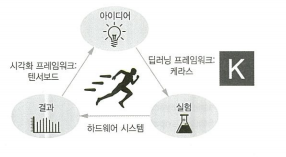

이 chapter에서는 tensorflow와 함께 제공되는 브라우저 기반 시각화 도구인 **tensor board**를 소개한다   
(tensor flow 백엔드로 케라스를 설정한 경우에만 케라스 model에서 사용할 수 있다)

#### 1. Tensor Board의 기능 
1. 훈련하는 동안 matric을 시각적으로 모니터링한다
2. model 구조를 시각화한다
3. 활성화 출력과 gradient histogram을 그린다
4. 3D로 embedding을 표현한다.

ex) IMDB 영화리뷰 감성 분석 문제를 위해 1D convnet을 훈련
- IMDB data set: 인터넷 영화 데이터베이스로부터 가져온 양극단의 리뷰 5만개로 이뤄진 data set이다
    + train data: 2만 5000개, test data: 2만 5000개로 나뉘어 있으며, 각각 긍정과 부정이 50%를 차지한다
    + 빈도가 높은 2000개의 단어만 사용할 것!-> 단어 embedding을 시각화하기 조금 더 쉬워짐

In [44]:
import keras
from keras import layers
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features=2000 # feature로 사용할 단어의 수
max_len=500 #사용할 text의 길이

(x_train, y_train),(x_test,y_test)=imdb.load_data(num_words=max_features)


def vectorize_sequences(sequences, dimension=max_features):
    # 크기가 (len(sequences), dimension))이고 모든 원소가 0인 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # results[i]에서 특정 인덱스의 위치를 1로 만듭니다
    return results

# 훈련 데이터를 벡터로 변환합니다
x_train = vectorize_sequences(x_train)
# 테스트 데이터를 벡터로 변환합니다
x_test = vectorize_sequences(x_test)


#This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps).
#x_trian= sequence.pad_sequences(x_train, maxlen=max_len)
#x_test= sequence.pad_sequences(x_test, maxlen=max_len)

y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

model=keras.models.Sequential()
model.add(layers.Embedding(max_features,128,input_length=max_len, name='embed'))
model.add(layers.Conv1D(32,7,activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32,7,activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 500, 128)          256000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 291,937
Trainable params: 291,937
Non-trainable params: 0
________________________________________________

tensor board를 시작 전에 log 파일이 저장될 directory를 만들어야 한다

In [31]:
mkdir my_log_dir

In [45]:
callbacks=[
    keras.callbacks.TensorBoard(
        # log파일이 기록될 위치
        log_dir='my_log_dir',
        # 1 epoch마다 활성화 출력의 histogram을 기록
        histogram_freq=1, 
        # 1 epoch마다 embedding을 기록한다
        embeddings_freq=1)
]

In [46]:
history=model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=callbacks)

Epoch 1/20
157/157 [==============================] - 69s 436ms/step - loss: 7.7643 - acc: 0.4966 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 2/20
157/157 [==============================] - 70s 447ms/step - loss: 7.7407 - acc: 0.4982 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 3/20
157/157 [==============================] - 67s 428ms/step - loss: 7.6880 - acc: 0.5016 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 4/20
157/157 [==============================] - 67s 427ms/step - loss: 7.7140 - acc: 0.4999 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 5/20
157/157 [==============================] - 68s 432ms/step - loss: 7.7044 - acc: 0.5005 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 6/20
157/157 [==============================] - 66s 424ms/step - loss: 7.7244 - acc: 0.4992 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 7/20
157/157 [==============================] - 67s 426ms/step - loss: 7.7128 - acc: 0.5000 - val_loss: 7.6168 - val_acc: 0.5062
Epoch 8/20
157/157 [==============================] - 6

`tensorboard --logdir=my_log_dir`

In [51]:
from keras.utils import plot_model

plot_model(model, to_file='model.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [58]:
from keras.utils import plot_model

plot_model(model, to_file='model.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [59]:
from keras.utils import plot_model

plot_model(model, show_shapes=True, to_file='model.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
